In [1]:
import numpy as np
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import pdb

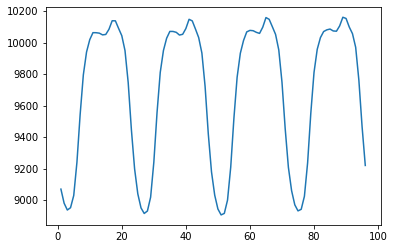

In [2]:
df = pd.read_csv('AESO_2020_demand_price.csv')
HE = []
end_index = df.shape[0]//(48 * 2) + 1
for day in range(1, end_index):
    for hour in range(1, (2 * 48) + 1):
        HE.append(hour)
df['HE'] = HE
df = df.drop(df.columns[[0, 2]], axis = 1)
df = df.set_index('HE', drop = True)
df = df.groupby('HE', as_index=True).mean()
df_to_plot = df.drop(df.columns[[0]], axis = 1)
plt.plot(df_to_plot);

In [3]:
alberta_avg_power_price = np.array(df.iloc[7:48+7, 0])
alberta_avg_demand = np.array(df.iloc[7:48+7, 1])

(48,)


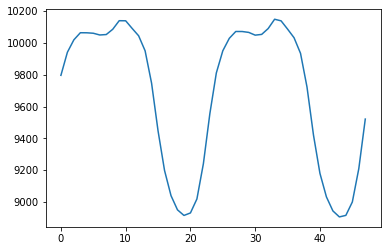

In [4]:
print(alberta_avg_demand.shape)
plt.plot(alberta_avg_demand);

In [5]:
# https://open.alberta.ca/dataset/d6205817-b04b-4360-8bb0-79eaaecb9df9/
# resource/4a06c219-03d1-4027-9c1f-a383629ab3bc/download/trans-motorized-
# vehicle-registrations-select-municipalities-2020.pdf
total_cars_in_alberta = 100
ev_market_penetration = 0.1
# SOC params
min_soc_by_8_am = 0.5
max_soc_allowed = 1
min_soc_allowed = 0.1
# Charging and discharging
charging_soc_addition_per_time_unit_per_ev = 0.15
discharging_soc_reduction_per_time_unit_per_ev = -0.15
# Power to the grid units in MWs
charging_soc_mw_addition_to_demand_per_time_unit_per_ev = 0.01
discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = 0.01
# Driving
driving_soc_reduction_per_time_unit_per_ev = 0.005
forecast_flag = False
n_percent_honesty = ['0.25', '0.5', '0.75', '1']

In [6]:
index_of_time = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
                 15,16,17,18,19,20,21,22,23,24,25,26,
                 27,28,29,30,31,32,33,34,35,36,37,38,
                 39,40,41,42,43,44,45,46,47]
time_of_day = [8,9,10,11,12,13,14,15,16,17,18,19,20,
               21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,
               13,14,15,16,17,18,19,20,21,22,23,0,1,2,
               3,4,5,6,7,8]

index_to_time_of_day_dict = {}
for item in range(len(index_of_time)):
    index_to_time_of_day_dict[index_of_time[item]] = time_of_day[item]
pprint(index_to_time_of_day_dict)

{0: 8,
 1: 9,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 20,
 13: 21,
 14: 22,
 15: 23,
 16: 0,
 17: 1,
 18: 2,
 19: 3,
 20: 4,
 21: 5,
 22: 6,
 23: 7,
 24: 8,
 25: 9,
 26: 10,
 27: 11,
 28: 12,
 29: 13,
 30: 14,
 31: 15,
 32: 16,
 33: 17,
 34: 18,
 35: 19,
 36: 20,
 37: 21,
 38: 22,
 39: 23,
 40: 0,
 41: 1,
 42: 2,
 43: 3,
 44: 4,
 45: 5,
 46: 6,
 47: 7}


In [7]:
# Define experiment params
experiment_params = {'n_episodes': 200, 
                     'n_hours': 48, 
                     'n_divisions_for_soc': 10, 
                     'n_divisions_for_percent_honesty': 4,
                     'max_soc_allowed': 1,
                     'min_soc_allowed': 0.1,
                     'alpha': 0.01,
                     'epsilon': 0.1,
                     'gamma': 1,
                     'total_cars_in_alberta': 1000000,
                     'ev_market_penetration': 0.1,
                     'charging_soc_addition_per_time_unit_per_ev': 0.15, 
                     'discharging_soc_reduction_per_time_unit_per_ev': 0.15, 
                     'charging_soc_mw_addition_to_demand_per_time_unit_per_ev': 0.01, 
                     'discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev': 0.01,
                     'driving_soc_reduction_per_km_per_ev': 0.005,
                     'alberta_average_demand': alberta_avg_demand,
                     'index_to_time_of_day_dict': index_to_time_of_day_dict,
                     'forecast_flag': forecast_flag,
                     'n_percent_honesty': n_percent_honesty
                    }

In [8]:
# Experiment function
class Experiment():
    
    def __init__(self, experiment_params={}):
        
        # Initialize all experiment params
        self.n_episodes = experiment_params.get('n_episodes')
        self.n_hours = experiment_params.get('n_hours')
        self.n_divisions_for_soc = experiment_params.get('n_divisions_for_soc')
        self.n_divisions_for_percent_honesty = experiment_params.get('n_divisions_for_percent_honesty')
        self.max_soc_allowed = experiment_params.get('max_soc_allowed')
        self.min_soc_allowed = experiment_params.get('in_soc_allowed')
        self.alpha = experiment_params.get('alpha')
        self.epsilon = experiment_params.get('epsilon')
        self.gamma = experiment_params.get('gamma')
        self.total_cars_in_alberta = experiment_params.get('total_cars_in_alberta')
        self.ev_market_penetration = experiment_params.get('ev_market_penetration')
        self.charging_soc_addition_per_time_unit_per_ev = experiment_params.get('charging_soc_addition_'\
                                                                           'per_time_unit_per_ev')
        self.discharging_soc_reduction_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                               'soc_reduction_per_time_unit_per_ev')
        self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev = experiment_params.get('charging_'\
                                                                                        'soc_mw_addition_to_demand_'\
                                                                                        'per_time_unit_per_ev') 
        self.discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev = experiment_params.get('discharging_'\
                                                                                              'soc_mw_reduction_'\
                                                                                              'from_demand_per_'
                                                                                              'time_unit_per_ev')
        self.driving_soc_reduction_per_km_per_ev = experiment_params.get('driving_soc_reduction_per_km_per_ev')
        self.alberta_average_demand = experiment_params.get('alberta_average_demand')
        self.index_to_time_of_day_dict = experiment_params.get('index_to_time_of_day_dict')
        self.forecast_flag = experiment_params.get('forecast_flag')
        self.n_percent_honesty = experiment_params.get('n_percent_honesty')
            
        # Initialize q-value table    
        self.Q = self.initialize_action_value()
        
        # Display params
        print('Experiment parameters are: ')
        print(*experiment_params.items(), sep='\n')
            
    def start_experiment(self):
        """Initialize the experiment"""
        
        # Calculate the number of EVs in the province
        self.num_of_evs = self.total_cars_in_alberta * self.ev_market_penetration
             
        # Initialize an array of SOCs for each EV
        self.soc_of_evs = [0.5] * int(self.num_of_evs)
        
#         # Initialize the charge status of each EV
#         self.charge_status_of_evs = []
        
#         # Initialize the array of driving distance for each EV
#         self.driving_distance_of_evs = []
        
        # Initialize the last total load and average
        self.last_total_load = 0
        self.last_average = 1
        self.last_percent_honest = np.random.choice(self.n_percent_honesty)

    def run(self):
        """Main method to run the experiment with initialized params"""
        
        # Monitor the trace as the program runs
        #pdb.set_trace()
        
        self.reward_list = []
        self.average_list = []
        # Repeat for every episode
        for episode in tqdm(range(self.n_episodes), ncols=100):
            
            print('-----------------------Starting Episode----------------------------------------------')
            
            # Initialize the experiment
            self.start_experiment()
            
            # Calculate the percent honesty of people 
            percent_honest = self.last_percent_honest #comes out as string
            
            # Repeat for every hour in the number of hours
            for hour in range(0, self.n_hours):
                
                # Calculate the percent honesty for the next hour
                if forecast_flag:
                    next_percent_honest = np.random.choice(self.n_percent_honesty, p = [0.25, 0.25, 0.25, 0.25])
                else:
                    next_percent_honest = np.random.choice(self.n_percent_honesty)
                    
                # Get the SOC division for each EV
                soc_div_index = self.get_division_index()
                
                # Get the indicator which shows whether each EV is
                # keeping to its original intention and make sure 
                # its applied randomly to each EV via shuffling
                status_evs = ([1] * int(self.num_of_evs * (1 - float(percent_honest))) 
                              + [0] * int(self.num_of_evs * float(percent_honest)))
                np.random.shuffle(status_evs)
                
                # Dictionary keeping track of what actions
                # were taken for each SOC division
                div_to_action_dict = {}
                
                # Loop for every SOC division
                for division in range(0, self.n_divisions_for_soc):
                    
                    # Extract the q-value for the division, hour, 
                    # and percent of EVs st
                    Q = self.Q[division][hour][int(float(percent_honest)/0.25 - 1)]
                    # Choose an action using a policy 
                    # (ex: epsilon-greedy)
                    action = self.choose_action(Q)
                    # Calculate the load for each SOC division 
                    #percent_honest = float(percent_honest) 
                    #next_percent_honest = float(next_percent_honest)
                    
                    if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
                        driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
                        soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                        for ii, soc in enumerate(self.soc_of_evs):
                            if soc_div_index[ii] == division:
                                self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        e_evs = 0
            
                    elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:

                        charging_load = 0
                        discharging_load = 0
                        driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                        else:
                            #do nothing
                            #discharging for driving
                            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 0:
                                        self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]

                        e_evs = charging_load - discharging_load

                    elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:

                        charging_load = 0
                        discharging_load = 0

                        if action == 0:
                            #charging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 1:
                                            charging_load += 0
                                        else:
                                            charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        elif action == 1:
                            #discharging for soc
                            for ii, soc in enumerate(self.soc_of_evs):
                                if soc_div_index[ii] == division:
                                    if status_evs[ii] == 1:
                                        self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                                        if self.soc_of_evs[ii] == 0:
                                            discharging_load += 0
                                        else:
                                            discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                        else:
                            #do nothing
                            pass

                        if action == 0 or action == 1:
                            e_evs = charging_load - discharging_load
                        else:
                            e_evs = 0
                    
                    #print(f'Divsion {division}, hour {hour}, load = {load_from_division}')
                    # Populate division-to-action dictionary
                    # to preserve the action that was picked
                    # for each SOC division
                    div_to_action_dict[division] = (action, e_evs)
                
                # Get next hour based on current hour
                next_hour = self.get_next_hour(hour)
                
                # Calculate the total load based on
                # the loads from each SOC division
                total_load = 0
                for div in div_to_action_dict.keys():
                    total_load += div_to_action_dict[div][1]
                
                # Calculate the total power demand by adding the
                # power demand with the additional demand from EVs
                total_load += self.alberta_average_demand[self.index_to_time_of_day_dict[hour]]
                
                # Calculate the Peak-to-Average ratio and the reward
                # The reward 
                average = ((hour + 1 - 1) * self.last_average + total_load) / (hour + 1)
                reward = -max(total_load, self.last_total_load) / average
                
                # Update the qction-value function for each
                # SOC division, hour, and percent honesty
                for division in range(0, self.n_divisions_for_soc):

                    if next_hour <= 47:
                        delta = (reward 
                                 + self.gamma * np.max(self.Q[division][next_hour][int(float(next_percent_honest)//0.25-1)])
                                 - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]])
                        self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                    else:
                        delta = reward - self.Q[division][hour][int(float(percent_honest)//0.25-1)][div_to_action_dict[division][0]]
                        self.Q[division][hour][int(float(percent_honest)/0.25-1)][div_to_action_dict[division][0]] += self.alpha * delta
                
                # Store the total load and peak-to-average
                # ratio
                self.last_total_load = total_load
                self.last_average = average
                self.last_percent_honest = next_percent_honest
            print('Last total load: ', self.last_total_load)
            print('Last average: ', self.last_average)
            print('Reward: ', reward)
            self.reward_list.append(reward)
            self.average_list.append(average)
        
        print(self.Q)

    # Initialize action-values array
    def initialize_action_value(self):

#         dict_for_percent_honesty = {}
#         for item in self.n_percent_honesty:
#             dict_for_percent_honesty[item] = [0, 0, 0]
#         Q = self.n_divisions_for_soc * self.n_hours * [dict_for_percent_honesty]
#         Q = np.array(Q).reshape((self.n_divisions_for_soc, self.n_hours))
        Q = np.zeros(shape = (10, 48, 4, 3))

        return Q

    # Choose action using epsilon-greedy    
    def choose_action(self, Q):
        if np.random.random() < self.epsilon:
            action = np.random.choice([0, 1, 2])
        else:
            action = self.argmax(Q)
            
        return action
    
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

    # Get the load for each SOC division
    def get_load_from_action_for_div(self, 
                                     hour, 
                                     percent_honest, 
                                     action, 
                                     division, 
                                     soc_div_index, 
                                     status_evs, 
                                     next_percent_honest):
            
        if self.index_to_time_of_day_dict[hour] in [8,9,10,11,12,13,14,15]:
            
            driving_distance_of_evs = abs(np.random.normal(10, 5, int(self.num_of_evs)))
            soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
            for ii, soc in enumerate(self.soc_of_evs):
                if soc_div_index[ii] == division:
                    self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            e_evs = 0
            
        elif self.index_to_time_of_day_dict[hour] in [16,17,18,19,20,21,22,23,0,1,2]:
            
            charging_load = 0
            discharging_load = 0
            driving_distance_of_evs = np.random.normal(5, 5, int(self.num_of_evs))
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
            else:
                #do nothing
                #discharging for driving
                soc_reduction_for_evs = self.driving_soc_reduction_per_km_per_ev * driving_distance_of_evs
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 0:
                            self.soc_of_evs[ii] = soc - soc_reduction_for_evs[ii]
                
            e_evs = charging_load - discharging_load
            
        elif self.index_to_time_of_day_dict[hour] in [3,4,5,6,7]:
            
            charging_load = 0
            discharging_load = 0
            
            if action == 0:
                #charging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = min(1, soc + self.charging_soc_addition_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 1:
                                charging_load += 0
                            else:
                                charging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            elif action == 1:
                #discharging for soc
                for ii, soc in enumerate(self.soc_of_evs):
                    if soc_div_index[ii] == division:
                        if status_evs[ii] == 1:
                            self.soc_of_evs[ii] = max(0, soc - self.discharging_soc_reduction_per_time_unit_per_ev)
                            if self.soc_of_evs[ii] == 0:
                                discharging_load += 0
                            else:
                                discharging_load += self.charging_soc_mw_addition_to_demand_per_time_unit_per_ev
            else:
                #do nothing
                pass
                
            if action == 0 or action == 1:
                e_evs = charging_load - discharging_load
            else:
                e_evs = 0
        
        return e_evs
    
    # Get the next hour based on
    # the current hour
    def get_next_hour(self, hour):

        if hour < 47:
            next_hour = hour + 1
        else:
            next_hour = 0
            
        return next_hour
    
    # Get the list of the SOC
    # division for each EV
    def get_division_index(self):
        
        soc_index = []
        for item in self.soc_of_evs:
            index = self.switch_index(item)
            soc_index.append(index)
            
        return soc_index
    
    # Get the SOC division
    # based on the SOC
    def switch_index(self, soc):
        
        if 0 < soc <= 0.1:
            index = 0
        elif soc <= 0.2:
            index = 1
        elif soc <= 0.3:
            index = 2
        elif soc <= 0.4:
            index = 3
        elif soc <= 0.5:
            index = 4
        elif soc <= 0.6:
            index = 5
        elif soc <= 0.7:
            index = 6
        elif soc <= 0.8:
            index = 7
        elif soc <= 0.9:
            index = 8
        elif soc <= 1:
            index = 9
        else:
            index = 'discharged'
            
        return index
    
    # Show the calculated policy
    def render_policy(self):
        pass

In [9]:
# Run experiment
experiment = Experiment(experiment_params)
experiment.run()

  0%|                                                                       | 0/200 [00:00<?, ?it/s]

Experiment parameters are: 
('n_episodes', 200)
('n_hours', 48)
('n_divisions_for_soc', 10)
('n_divisions_for_percent_honesty', 4)
('max_soc_allowed', 1)
('min_soc_allowed', 0.1)
('alpha', 0.01)
('epsilon', 0.1)
('gamma', 1)
('total_cars_in_alberta', 1000000)
('ev_market_penetration', 0.1)
('charging_soc_addition_per_time_unit_per_ev', 0.15)
('discharging_soc_reduction_per_time_unit_per_ev', 0.15)
('charging_soc_mw_addition_to_demand_per_time_unit_per_ev', 0.01)
('discharging_soc_mw_reduction_from_demand_per_time_unit_per_ev', 0.01)
('driving_soc_reduction_per_km_per_ev', 0.005)
('alberta_average_demand', array([ 9796.02197802,  9940.9010989 , 10019.        , 10063.54945055,
       10063.20879121, 10060.35164835, 10049.46153846, 10052.23076923,
       10085.14285714, 10139.13186813, 10138.62637363, 10090.64835165,
       10044.3956044 ,  9950.0989011 ,  9746.67032967,  9446.98901099,
        9198.65934066,  9040.31868132,  8951.08791209,  8915.9010989 ,
        8931.57142857,  9019.472

  0%|▎                                                              | 1/200 [00:10<36:22, 10.97s/it]

Last total load:  9938.570769230768
Last average:  9795.664457417524
Reward:  -1.0472308012442828
-----------------------Starting Episode----------------------------------------------


  1%|▋                                                              | 2/200 [00:21<35:35, 10.78s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  2%|▉                                                              | 3/200 [00:32<35:49, 10.91s/it]

Last total load:  10493.730769230595
Last average:  9782.366124084203
Reward:  -1.072719077994332
-----------------------Starting Episode----------------------------------------------


  2%|█▎                                                             | 4/200 [00:42<34:58, 10.71s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  2%|█▌                                                             | 5/200 [00:54<35:20, 10.88s/it]

Last total load:  10253.820769230731
Last average:  9753.714040750907
Reward:  -1.052523325532225
-----------------------Starting Episode----------------------------------------------


  3%|█▉                                                             | 6/200 [01:06<36:25, 11.26s/it]

Last total load:  9791.620769230782
Last average:  9791.976124084198
Reward:  -1.0015150582670393
-----------------------Starting Episode----------------------------------------------


  4%|██▏                                                            | 7/200 [01:16<35:32, 11.05s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  4%|██▌                                                            | 8/200 [01:27<34:42, 10.85s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  4%|██▊                                                            | 9/200 [01:38<34:50, 10.94s/it]

Last total load:  10059.08076923077
Last average:  9804.80279075083
Reward:  -1.0406320000731215
-----------------------Starting Episode----------------------------------------------


  5%|███                                                           | 10/200 [01:48<34:22, 10.86s/it]

Last total load:  10081.50076923077
Last average:  9728.84841575091
Reward:  -1.0362481085540318
-----------------------Starting Episode----------------------------------------------


  6%|███▍                                                          | 11/200 [02:00<34:46, 11.04s/it]

Last total load:  10040.78076923077
Last average:  9769.82633241755
Reward:  -1.0277338027917813
-----------------------Starting Episode----------------------------------------------


  6%|███▋                                                          | 12/200 [02:11<34:11, 10.91s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  6%|████                                                          | 13/200 [02:22<34:11, 10.97s/it]

Last total load:  10042.210769230769
Last average:  9734.001540750915
Reward:  -1.0351849130367208
-----------------------Starting Episode----------------------------------------------


  7%|████▎                                                         | 14/200 [02:33<34:02, 10.98s/it]

Last total load:  10051.30076923077
Last average:  9723.827165750907
Reward:  -1.0336774397464903
-----------------------Starting Episode----------------------------------------------


  8%|████▋                                                         | 15/200 [02:43<33:23, 10.83s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  8%|████▉                                                         | 16/200 [02:55<33:51, 11.04s/it]

Last total load:  9923.430769230767
Last average:  9774.960082417547
Reward:  -1.0670827758389854
-----------------------Starting Episode----------------------------------------------


  8%|█████▎                                                        | 17/200 [03:05<33:06, 10.86s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


  9%|█████▌                                                        | 18/200 [03:15<32:29, 10.71s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 10%|█████▉                                                        | 19/200 [03:26<31:45, 10.53s/it]

Last total load:  10766.260769230348
Last average:  9747.275082417536
Reward:  -1.104540569358804
-----------------------Starting Episode----------------------------------------------


 10%|██████▏                                                       | 20/200 [03:36<31:40, 10.56s/it]

Last total load:  10072.83076923077
Last average:  9720.595082417578
Reward:  -1.058797475997914
-----------------------Starting Episode----------------------------------------------


 10%|██████▌                                                       | 21/200 [03:47<31:24, 10.53s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 11%|██████▊                                                       | 22/200 [03:57<31:04, 10.48s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 12%|███████▏                                                      | 23/200 [04:08<31:34, 10.71s/it]

Last total load:  10193.01076923077
Last average:  9763.343207417574
Reward:  -1.0440082410999094
-----------------------Starting Episode----------------------------------------------


 12%|███████▍                                                      | 24/200 [04:19<31:37, 10.78s/it]

Last total load:  10050.50076923077
Last average:  9716.043832417578
Reward:  -1.034423160556077
-----------------------Starting Episode----------------------------------------------


 12%|███████▊                                                      | 25/200 [04:31<32:11, 11.04s/it]

Last total load:  10169.39076923078
Last average:  9768.268207417539
Reward:  -1.0410638358095705
-----------------------Starting Episode----------------------------------------------


 13%|████████                                                      | 26/200 [04:41<31:23, 10.82s/it]

Last total load:  10030.610769230769
Last average:  9714.891124084235
Reward:  -1.0324985263462019
-----------------------Starting Episode----------------------------------------------


 14%|████████▎                                                     | 27/200 [04:52<30:58, 10.74s/it]

Last total load:  10053.52076923077
Last average:  9702.505082417583
Reward:  -1.0361778410659408
-----------------------Starting Episode----------------------------------------------


 14%|████████▋                                                     | 28/200 [05:02<30:34, 10.67s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 14%|████████▉                                                     | 29/200 [05:14<30:59, 10.87s/it]

Last total load:  10484.210769230667
Last average:  9786.242374084204
Reward:  -1.0727888332567266
-----------------------Starting Episode----------------------------------------------


 15%|█████████▎                                                    | 30/200 [05:26<31:46, 11.22s/it]

Last total load:  9911.590769230765
Last average:  9788.569040750906
Reward:  -1.0321929075024905
-----------------------Starting Episode----------------------------------------------


 16%|█████████▌                                                    | 31/200 [05:36<30:52, 10.96s/it]

Last total load:  10476.950769230512
Last average:  9733.83404075089
Reward:  -1.0763436817772474
-----------------------Starting Episode----------------------------------------------


 16%|█████████▉                                                    | 32/200 [05:47<30:39, 10.95s/it]

Last total load:  10086.51076923077
Last average:  9723.733832417567
Reward:  -1.0373083985087863
-----------------------Starting Episode----------------------------------------------


 16%|██████████▏                                                   | 33/200 [05:59<31:42, 11.39s/it]

Last total load:  10158.650769230784
Last average:  9830.827999084226
Reward:  -1.0565601940578278
-----------------------Starting Episode----------------------------------------------


 17%|██████████▌                                                   | 34/200 [06:12<32:57, 11.91s/it]

Last total load:  10501.400769230708
Last average:  9831.247582417547
Reward:  -1.0681656301700386
-----------------------Starting Episode----------------------------------------------


 18%|██████████▊                                                   | 35/200 [06:23<31:26, 11.44s/it]

Last total load:  10048.960769230769
Last average:  9703.513624084238
Reward:  -1.0356002123075425
-----------------------Starting Episode----------------------------------------------


 18%|███████████▏                                                  | 36/200 [06:34<31:12, 11.42s/it]

Last total load:  10253.800769230751
Last average:  9782.724665750911
Reward:  -1.0522233723391203
-----------------------Starting Episode----------------------------------------------


 18%|███████████▍                                                  | 37/200 [06:45<30:22, 11.18s/it]

Last total load:  10036.51076923077
Last average:  9700.549249084244
Reward:  -1.0358899563764559
-----------------------Starting Episode----------------------------------------------


 19%|███████████▊                                                  | 38/200 [06:55<29:51, 11.06s/it]

Last total load:  10050.860769230769
Last average:  9726.847374084244
Reward:  -1.0333112449168074
-----------------------Starting Episode----------------------------------------------


 20%|████████████                                                  | 39/200 [07:06<29:16, 10.91s/it]

Last total load:  10052.65076923077
Last average:  9699.778624084245
Reward:  -1.0367454689627975
-----------------------Starting Episode----------------------------------------------


 20%|████████████▍                                                 | 40/200 [07:18<29:36, 11.10s/it]

Last total load:  10251.580769230768
Last average:  9783.459457417577
Reward:  -1.0478482395568445
-----------------------Starting Episode----------------------------------------------


 20%|████████████▋                                                 | 41/200 [07:28<29:04, 10.97s/it]

Last total load:  10058.460769230769
Last average:  9707.262582417583
Reward:  -1.0361789107723633
-----------------------Starting Episode----------------------------------------------


 21%|█████████████                                                 | 42/200 [07:39<28:26, 10.80s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▎                                                | 43/200 [07:51<29:29, 11.27s/it]

Last total load:  10427.690769230798
Last average:  9830.590290750884
Reward:  -1.0607390259201115
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▋                                                | 44/200 [08:02<29:01, 11.16s/it]

Last total load:  10052.99076923077
Last average:  9708.581957417578
Reward:  -1.0359341438918808
-----------------------Starting Episode----------------------------------------------


 22%|█████████████▉                                                | 45/200 [08:13<28:32, 11.05s/it]

Last total load:  10045.370769230769
Last average:  9725.11758241756
Reward:  -1.032930520798248
-----------------------Starting Episode----------------------------------------------


 23%|██████████████▎                                               | 46/200 [08:24<28:35, 11.14s/it]

Last total load:  10181.99076923078
Last average:  9778.497790750907
Reward:  -1.0471875903216006
-----------------------Starting Episode----------------------------------------------


 24%|██████████████▌                                               | 47/200 [08:35<28:05, 11.01s/it]

Last total load:  10049.190769230769
Last average:  9714.65112408424
Reward:  -1.0344366092897717
-----------------------Starting Episode----------------------------------------------


 24%|██████████████▉                                               | 48/200 [08:46<27:42, 10.94s/it]

Last total load:  10057.140769230768
Last average:  9721.42883241757
Reward:  -1.0345331887524307
-----------------------Starting Episode----------------------------------------------


 24%|███████████████▏                                              | 49/200 [08:56<27:15, 10.83s/it]

Last total load:  10052.59076923077
Last average:  9692.434457417585
Reward:  -1.0378034107585368
-----------------------Starting Episode----------------------------------------------


 25%|███████████████▌                                              | 50/200 [09:06<26:41, 10.68s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 26%|███████████████▊                                              | 51/200 [09:17<26:23, 10.63s/it]

Last total load:  10042.43076923077
Last average:  9733.202999084215
Reward:  -1.0317704018066458
-----------------------Starting Episode----------------------------------------------


 26%|████████████████                                              | 52/200 [09:29<27:31, 11.16s/it]

Last total load:  10080.190769230787
Last average:  9821.302374084227
Reward:  -1.0629498146812693
-----------------------Starting Episode----------------------------------------------


 26%|████████████████▍                                             | 53/200 [09:41<27:42, 11.31s/it]

Last total load:  10215.470769230778
Last average:  9790.865499084246
Reward:  -1.0460884729158528
-----------------------Starting Episode----------------------------------------------


 27%|████████████████▋                                             | 54/200 [09:51<26:47, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████                                             | 55/200 [10:02<26:14, 10.86s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████▎                                            | 56/200 [10:13<26:17, 10.95s/it]

Last total load:  10181.740769230772
Last average:  9792.174665750861
Reward:  -1.0433271349003395
-----------------------Starting Episode----------------------------------------------


 28%|█████████████████▋                                            | 57/200 [10:26<27:17, 11.45s/it]

Last total load:  10741.480769230444
Last average:  9805.98716575085
Reward:  -1.095400247590265
-----------------------Starting Episode----------------------------------------------


 29%|█████████████████▉                                            | 58/200 [10:36<26:15, 11.10s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▎                                           | 59/200 [10:47<25:48, 10.98s/it]

Last total load:  10046.90076923077
Last average:  9716.931540750915
Reward:  -1.033958171578757
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▌                                           | 60/200 [10:57<25:17, 10.84s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 30%|██████████████████▉                                           | 61/200 [11:08<25:03, 10.81s/it]

Last total load:  10052.92076923077
Last average:  9700.071332417583
Reward:  -1.0366152158960913
-----------------------Starting Episode----------------------------------------------


 31%|███████████████████▏                                          | 62/200 [11:18<24:40, 10.73s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 32%|███████████████████▌                                          | 63/200 [11:29<24:15, 10.62s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 32%|███████████████████▊                                          | 64/200 [11:39<23:47, 10.50s/it]

Last total load:  9992.050769230767
Last average:  9724.483207417552
Reward:  -1.0329455380003754
-----------------------Starting Episode----------------------------------------------


 32%|████████████████████▏                                         | 65/200 [11:50<24:08, 10.73s/it]

Last total load:  10076.59076923077
Last average:  9810.904040750858
Reward:  -1.0270807590591395
-----------------------Starting Episode----------------------------------------------


 33%|████████████████████▍                                         | 66/200 [12:01<23:46, 10.64s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 34%|████████████████████▊                                         | 67/200 [12:12<23:46, 10.72s/it]

Last total load:  10461.620769230523
Last average:  9750.398415750884
Reward:  -1.072942901731146
-----------------------Starting Episode----------------------------------------------


 34%|█████████████████████                                         | 68/200 [12:23<23:59, 10.90s/it]

Last total load:  10204.900769230784
Last average:  9783.175915750908
Reward:  -1.0470262036247289
-----------------------Starting Episode----------------------------------------------


 34%|█████████████████████▍                                        | 69/200 [12:34<23:42, 10.86s/it]

Last total load:  10065.99076923077
Last average:  9724.079665750898
Reward:  -1.0351612816053033
-----------------------Starting Episode----------------------------------------------


 35%|█████████████████████▋                                        | 70/200 [12:44<23:13, 10.72s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 36%|██████████████████████                                        | 71/200 [12:55<23:06, 10.75s/it]

Last total load:  10049.72076923077
Last average:  9707.12612408425
Reward:  -1.0352931074313036
-----------------------Starting Episode----------------------------------------------


 36%|██████████████████████▎                                       | 72/200 [13:06<22:51, 10.72s/it]

Last total load:  10047.040769230769
Last average:  9707.901124084243
Reward:  -1.0376982016709426
-----------------------Starting Episode----------------------------------------------


 36%|██████████████████████▋                                       | 73/200 [13:19<24:17, 11.47s/it]

Last total load:  10440.160769230715
Last average:  9819.625290750877
Reward:  -1.0631933969073466
-----------------------Starting Episode----------------------------------------------


 37%|██████████████████████▉                                       | 74/200 [13:30<24:07, 11.49s/it]

Last total load:  10278.890769230786
Last average:  9793.702790750916
Reward:  -1.049540810952327
-----------------------Starting Episode----------------------------------------------


 38%|███████████████████████▎                                      | 75/200 [13:41<23:13, 11.15s/it]

Last total load:  10009.270769230769
Last average:  9745.64841575087
Reward:  -1.0323419344988123
-----------------------Starting Episode----------------------------------------------


 38%|███████████████████████▌                                      | 76/200 [13:52<23:15, 11.25s/it]

Last total load:  9995.250769230774
Last average:  9778.171749084202
Reward:  -1.028720071255001
-----------------------Starting Episode----------------------------------------------


 38%|███████████████████████▊                                      | 77/200 [14:03<22:30, 10.98s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 39%|████████████████████████▏                                     | 78/200 [14:14<22:20, 10.98s/it]

Last total load:  10049.63076923077
Last average:  9717.364665750914
Reward:  -1.034193026083598
-----------------------Starting Episode----------------------------------------------


 40%|████████████████████████▍                                     | 79/200 [14:26<22:55, 11.37s/it]

Last total load:  10397.860769230732
Last average:  9826.46654075089
Reward:  -1.0581484937754828
-----------------------Starting Episode----------------------------------------------


 40%|████████████████████████▊                                     | 80/200 [14:37<22:42, 11.35s/it]

Last total load:  10049.84076923077
Last average:  9756.55799908422
Reward:  -1.0300600652580632
-----------------------Starting Episode----------------------------------------------


 40%|█████████████████████████                                     | 81/200 [14:48<22:14, 11.21s/it]

Last total load:  10055.02076923077
Last average:  9714.04383241758
Reward:  -1.0355719731149247
-----------------------Starting Episode----------------------------------------------


 41%|█████████████████████████▍                                    | 82/200 [15:01<23:02, 11.71s/it]

Last total load:  10532.480769230546
Last average:  9806.610082417536
Reward:  -1.0740185120763024
-----------------------Starting Episode----------------------------------------------


 42%|█████████████████████████▋                                    | 83/200 [15:11<21:57, 11.26s/it]

Last total load:  10060.41076923077
Last average:  9741.008207417543
Reward:  -1.1086277014157235
-----------------------Starting Episode----------------------------------------------


 42%|██████████████████████████                                    | 84/200 [15:22<21:17, 11.02s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 42%|██████████████████████████▎                                   | 85/200 [15:32<20:45, 10.83s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 43%|██████████████████████████▋                                   | 86/200 [15:43<20:31, 10.80s/it]

Last total load:  10043.55076923077
Last average:  9708.342790750905
Reward:  -1.034994515030341
-----------------------Starting Episode----------------------------------------------


 44%|██████████████████████████▉                                   | 87/200 [15:55<20:56, 11.12s/it]

Last total load:  10347.810769230815
Last average:  9815.503207417552
Reward:  -1.060555054436213
-----------------------Starting Episode----------------------------------------------


 44%|███████████████████████████▎                                  | 88/200 [16:06<20:47, 11.14s/it]

Last total load:  10080.37076923077
Last average:  9746.711957417556
Reward:  -1.0342329611535601
-----------------------Starting Episode----------------------------------------------


 44%|███████████████████████████▌                                  | 89/200 [16:17<20:44, 11.21s/it]

Last total load:  10252.16076923075
Last average:  9771.948832417578
Reward:  -1.0504282937308445
-----------------------Starting Episode----------------------------------------------


 45%|███████████████████████████▉                                  | 90/200 [16:28<20:19, 11.08s/it]

Last total load:  10049.290769230769
Last average:  9723.805499084241
Reward:  -1.0334730338011369
-----------------------Starting Episode----------------------------------------------


 46%|████████████████████████████▏                                 | 91/200 [16:39<20:02, 11.03s/it]

Last total load:  10042.43076923077
Last average:  9773.259249084194
Reward:  -1.0275416330710554
-----------------------Starting Episode----------------------------------------------


 46%|████████████████████████████▌                                 | 92/200 [16:49<19:38, 10.91s/it]

Last total load:  10053.40076923077
Last average:  9695.92320741758
Reward:  -1.0372525981608058
-----------------------Starting Episode----------------------------------------------


 46%|████████████████████████████▊                                 | 93/200 [17:00<19:16, 10.81s/it]

Last total load:  10039.790769230769
Last average:  9713.199040750902
Reward:  -1.0361634201293461
-----------------------Starting Episode----------------------------------------------


 47%|█████████████████████████████▏                                | 94/200 [17:10<18:48, 10.65s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 48%|█████████████████████████████▍                                | 95/200 [17:23<20:00, 11.43s/it]

Last total load:  10443.54076923082
Last average:  9831.639040750892
Reward:  -1.062238018090745
-----------------------Starting Episode----------------------------------------------


 48%|█████████████████████████████▊                                | 96/200 [17:35<19:51, 11.46s/it]

Last total load:  10241.290769230758
Last average:  9783.313415750907
Reward:  -1.0489055294845508
-----------------------Starting Episode----------------------------------------------


 48%|██████████████████████████████                                | 97/200 [17:47<20:10, 11.76s/it]

Last total load:  10457.430769230796
Last average:  9818.917999084233
Reward:  -1.0650288321183774
-----------------------Starting Episode----------------------------------------------


 49%|██████████████████████████████▍                               | 98/200 [17:58<19:29, 11.47s/it]

Last total load:  10049.72076923077
Last average:  9713.514665750912
Reward:  -1.0346121990905406
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▋                               | 99/200 [18:09<18:52, 11.21s/it]

Last total load:  10062.97076923077
Last average:  9706.119874084243
Reward:  -1.0381626921141076
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▌                              | 100/200 [18:19<18:23, 11.03s/it]

Last total load:  10044.69076923077
Last average:  9725.179457417562
Reward:  -1.0328540273433733
-----------------------Starting Episode----------------------------------------------


 50%|██████████████████████████████▊                              | 101/200 [18:30<18:02, 10.94s/it]

Last total load:  10081.71076923077
Last average:  9716.35424908424
Reward:  -1.0376022230952486
-----------------------Starting Episode----------------------------------------------


 51%|███████████████████████████████                              | 102/200 [18:42<18:10, 11.13s/it]

Last total load:  10251.900769230773
Last average:  9796.641540750918
Reward:  -1.0464709489049
-----------------------Starting Episode----------------------------------------------


 52%|███████████████████████████████▍                             | 103/200 [18:52<17:38, 10.91s/it]

Last total load:  10052.22076923077
Last average:  9717.320082417556
Reward:  -1.034464305381808
-----------------------Starting Episode----------------------------------------------


 52%|███████████████████████████████▋                             | 104/200 [19:03<17:28, 10.92s/it]

Last total load:  10134.53076923077
Last average:  9764.524665750874
Reward:  -1.0378928945489476
-----------------------Starting Episode----------------------------------------------


 52%|████████████████████████████████                             | 105/200 [19:14<17:03, 10.77s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 53%|████████████████████████████████▎                            | 106/200 [19:27<18:03, 11.53s/it]

Last total load:  10367.990769230708
Last average:  9842.81174908421
Reward:  -1.0533566051586185
-----------------------Starting Episode----------------------------------------------


 54%|████████████████████████████████▋                            | 107/200 [19:39<18:12, 11.75s/it]

Last total load:  10359.100769230807
Last average:  9829.24841575089
Reward:  -1.0539056834326066
-----------------------Starting Episode----------------------------------------------


 54%|████████████████████████████████▉                            | 108/200 [19:50<17:27, 11.39s/it]

Last total load:  10052.040769230769
Last average:  9698.300290750918
Reward:  -1.0364744819066085
-----------------------Starting Episode----------------------------------------------


 55%|█████████████████████████████████▏                           | 109/200 [20:01<17:02, 11.24s/it]

Last total load:  10073.70076923077
Last average:  9730.089249084233
Reward:  -1.0353143235740492
-----------------------Starting Episode----------------------------------------------


 55%|█████████████████████████████████▌                           | 110/200 [20:11<16:40, 11.12s/it]

Last total load:  10057.26076923077
Last average:  9710.693415750911
Reward:  -1.036317501501859
-----------------------Starting Episode----------------------------------------------


 56%|█████████████████████████████████▊                           | 111/200 [20:22<16:17, 10.99s/it]

Last total load:  10048.530769230769
Last average:  9720.449249084222
Reward:  -1.035933759893888
-----------------------Starting Episode----------------------------------------------


 56%|██████████████████████████████████▏                          | 112/200 [20:33<16:18, 11.12s/it]

Last total load:  10198.310769230786
Last average:  9789.85508241757
Reward:  -1.0420441827359856
-----------------------Starting Episode----------------------------------------------


 56%|██████████████████████████████████▍                          | 113/200 [20:44<15:49, 10.91s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 57%|██████████████████████████████████▊                          | 114/200 [20:54<15:24, 10.75s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 57%|███████████████████████████████████                          | 115/200 [21:05<15:03, 10.63s/it]

Last total load:  10078.27076923077
Last average:  9760.761957417535
Reward:  -1.03252910102699
-----------------------Starting Episode----------------------------------------------


 58%|███████████████████████████████████▍                         | 116/200 [21:15<14:54, 10.65s/it]

Last total load:  10050.64076923077
Last average:  9711.427582417584
Reward:  -1.0349292813990938
-----------------------Starting Episode----------------------------------------------


 58%|███████████████████████████████████▋                         | 117/200 [21:28<15:41, 11.34s/it]

Last total load:  10366.070769230799
Last average:  9826.694874084218
Reward:  -1.0548888412694148
-----------------------Starting Episode----------------------------------------------


 59%|███████████████████████████████████▉                         | 118/200 [21:39<15:06, 11.05s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▎                        | 119/200 [21:49<14:44, 10.92s/it]

Last total load:  9982.510769230772
Last average:  9771.132582417526
Reward:  -1.0216329258691677
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▌                        | 120/200 [22:00<14:26, 10.83s/it]

Last total load:  10046.44076923077
Last average:  9693.855290750913
Reward:  -1.036663044480324
-----------------------Starting Episode----------------------------------------------


 60%|████████████████████████████████████▉                        | 121/200 [22:10<14:08, 10.74s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 61%|█████████████████████████████████████▏                       | 122/200 [22:23<14:34, 11.21s/it]

Last total load:  10290.100769230807
Last average:  9825.429874084233
Reward:  -1.0629928331186647
-----------------------Starting Episode----------------------------------------------


 62%|█████████████████████████████████████▌                       | 123/200 [22:33<14:01, 10.93s/it]

Last total load:  10052.72076923077
Last average:  9705.519249084236
Reward:  -1.0357736161493156
-----------------------Starting Episode----------------------------------------------


 62%|█████████████████████████████████████▊                       | 124/200 [22:43<13:35, 10.73s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 62%|██████████████████████████████████████▏                      | 125/200 [22:54<13:22, 10.69s/it]

Last total load:  10052.98076923077
Last average:  9696.388624084248
Reward:  -1.036775768687819
-----------------------Starting Episode----------------------------------------------


 63%|██████████████████████████████████████▍                      | 126/200 [23:04<13:03, 10.59s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 64%|██████████████████████████████████████▋                      | 127/200 [23:17<13:50, 11.38s/it]

Last total load:  10417.770769230814
Last average:  9835.27674908421
Reward:  -1.0845675023282626
-----------------------Starting Episode----------------------------------------------


 64%|███████████████████████████████████████                      | 128/200 [23:28<13:21, 11.13s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 64%|███████████████████████████████████████▎                     | 129/200 [23:38<12:54, 10.91s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 65%|███████████████████████████████████████▋                     | 130/200 [23:50<12:57, 11.10s/it]

Last total load:  10226.020769230769
Last average:  9783.217999084245
Reward:  -1.047899733954733
-----------------------Starting Episode----------------------------------------------


 66%|███████████████████████████████████████▉                     | 131/200 [24:01<12:39, 11.01s/it]

Last total load:  10063.14076923077
Last average:  9732.873624084228
Reward:  -1.0339331586849425
-----------------------Starting Episode----------------------------------------------


 66%|████████████████████████████████████████▎                    | 132/200 [24:11<12:21, 10.91s/it]

Last total load:  9833.700769230823
Last average:  9753.1536240842
Reward:  -1.0167882021229524
-----------------------Starting Episode----------------------------------------------


 66%|████████████████████████████████████████▌                    | 133/200 [24:22<12:04, 10.81s/it]

Last total load:  10073.540769230769
Last average:  9731.753415750885
Reward:  -1.035120839881403
-----------------------Starting Episode----------------------------------------------


 67%|████████████████████████████████████████▊                    | 134/200 [24:35<12:38, 11.49s/it]

Last total load:  10005.870769230765
Last average:  9838.565499084218
Reward:  -1.080441202475191
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▏                   | 135/200 [24:45<12:04, 11.15s/it]

Last total load:  10040.540769230769
Last average:  9712.420290750899
Reward:  -1.034684583000536
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▍                   | 136/200 [24:56<11:36, 10.89s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 68%|█████████████████████████████████████████▊                   | 137/200 [25:06<11:16, 10.74s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 69%|██████████████████████████████████████████                   | 138/200 [25:16<10:58, 10.61s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 70%|██████████████████████████████████████████▍                  | 139/200 [25:27<10:39, 10.48s/it]

Last total load:  10796.120769230238
Last average:  9721.822374084222
Reward:  -1.1105038082170486
-----------------------Starting Episode----------------------------------------------


 70%|██████████████████████████████████████████▋                  | 140/200 [25:37<10:34, 10.57s/it]

Last total load:  10049.06076923077
Last average:  9716.728207417582
Reward:  -1.0342021053505943
-----------------------Starting Episode----------------------------------------------


 70%|███████████████████████████████████████████                  | 141/200 [25:50<10:57, 11.14s/it]

Last total load:  10385.480769230811
Last average:  9825.17945741755
Reward:  -1.062803135934391
-----------------------Starting Episode----------------------------------------------


 71%|███████████████████████████████████████████▎                 | 142/200 [26:01<10:37, 11.00s/it]

Last total load:  10052.84076923077
Last average:  9704.791124084253
Reward:  -1.036009060876131
-----------------------Starting Episode----------------------------------------------


 72%|███████████████████████████████████████████▌                 | 143/200 [26:11<10:22, 10.92s/it]

Last total load:  10048.77076923077
Last average:  9734.527999084228
Reward:  -1.0322812539217212
-----------------------Starting Episode----------------------------------------------


 72%|███████████████████████████████████████████▉                 | 144/200 [26:21<10:00, 10.71s/it]

Last total load:  10068.610769230769
Last average:  9715.687790750899
Reward:  -1.036325063760884
-----------------------Starting Episode----------------------------------------------


 72%|████████████████████████████████████████████▏                | 145/200 [26:33<10:02, 10.96s/it]

Last total load:  10199.030769230782
Last average:  9780.462790750913
Reward:  -1.047948523269688
-----------------------Starting Episode----------------------------------------------


 73%|████████████████████████████████████████████▌                | 146/200 [26:43<09:41, 10.77s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 74%|████████████████████████████████████████████▊                | 147/200 [26:54<09:31, 10.78s/it]

Last total load:  10050.23076923077
Last average:  9716.003415750913
Reward:  -1.034399674349438
-----------------------Starting Episode----------------------------------------------


 74%|█████████████████████████████████████████████▏               | 148/200 [27:05<09:15, 10.69s/it]

Last total load:  10052.440769230769
Last average:  9695.633415750917
Reward:  -1.0370061560008799
-----------------------Starting Episode----------------------------------------------


 74%|█████████████████████████████████████████████▍               | 149/200 [27:16<09:15, 10.90s/it]

Last total load:  10212.910769230777
Last average:  9787.456332417583
Reward:  -1.0468819671280845
-----------------------Starting Episode----------------------------------------------


 75%|█████████████████████████████████████████████▊               | 150/200 [27:26<08:58, 10.77s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████               | 151/200 [27:37<08:49, 10.80s/it]

Last total load:  10041.59076923077
Last average:  9712.926957417581
Reward:  -1.0344823535183882
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████▎              | 152/200 [27:48<08:30, 10.64s/it]

Last total load:  10038.68076923077
Last average:  9699.86779075091
Reward:  -1.03572046085422
-----------------------Starting Episode----------------------------------------------


 76%|██████████████████████████████████████████████▋              | 153/200 [28:01<08:55, 11.40s/it]

Last total load:  10285.280769230734
Last average:  9833.016540750878
Reward:  -1.0633859401260648
-----------------------Starting Episode----------------------------------------------


 77%|██████████████████████████████████████████████▉              | 154/200 [28:13<08:57, 11.68s/it]

Last total load:  10402.740769230824
Last average:  9822.581332417578
Reward:  -1.067355024474111
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▎             | 155/200 [28:24<08:30, 11.35s/it]

Last total load:  10052.77076923077
Last average:  9697.004040750919
Reward:  -1.0368100803310565
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▌             | 156/200 [28:34<08:08, 11.09s/it]

Last total load:  10044.09076923077
Last average:  9720.395082417566
Reward:  -1.0333006718418998
-----------------------Starting Episode----------------------------------------------


 78%|███████████████████████████████████████████████▉             | 157/200 [28:46<08:03, 11.23s/it]

Last total load:  10248.950769230778
Last average:  9796.109249084246
Reward:  -1.0479600908310827
-----------------------Starting Episode----------------------------------------------


 79%|████████████████████████████████████████████████▏            | 158/200 [28:56<07:44, 11.06s/it]

Last total load:  10051.57076923077
Last average:  9700.392582417584
Reward:  -1.0362024715834401
-----------------------Starting Episode----------------------------------------------


 80%|████████████████████████████████████████████████▍            | 159/200 [29:07<07:27, 10.90s/it]

Last total load:  10052.120769230769
Last average:  9746.645915750873
Reward:  -1.105744646067893
-----------------------Starting Episode----------------------------------------------


 80%|████████████████████████████████████████████████▊            | 160/200 [29:18<07:15, 10.90s/it]

Last total load:  10050.16076923077
Last average:  9720.011540750898
Reward:  -1.0339659296797878
-----------------------Starting Episode----------------------------------------------


 80%|█████████████████████████████████████████████████            | 161/200 [29:29<07:03, 10.87s/it]

Last total load:  10052.48076923077
Last average:  9694.68841575091
Reward:  -1.0369060188565273
-----------------------Starting Episode----------------------------------------------


 81%|█████████████████████████████████████████████████▍           | 162/200 [29:39<06:48, 10.74s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 82%|█████████████████████████████████████████████████▋           | 163/200 [29:51<06:47, 11.02s/it]

Last total load:  10223.470769230767
Last average:  9792.011749084244
Reward:  -1.0440623470643684
-----------------------Starting Episode----------------------------------------------


 82%|██████████████████████████████████████████████████           | 164/200 [30:03<06:50, 11.41s/it]

Last total load:  10188.160769230775
Last average:  9827.206540750898
Reward:  -1.0451476211343342
-----------------------Starting Episode----------------------------------------------


 82%|██████████████████████████████████████████████████▎          | 165/200 [30:14<06:34, 11.26s/it]

Last total load:  10064.800769230771
Last average:  9732.28195741756
Reward:  -1.0341665822330373
-----------------------Starting Episode----------------------------------------------


 83%|██████████████████████████████████████████████████▋          | 166/200 [30:25<06:17, 11.09s/it]

Last total load:  10044.290769230769
Last average:  9717.584874084232
Reward:  -1.0336200711781613
-----------------------Starting Episode----------------------------------------------


 84%|██████████████████████████████████████████████████▉          | 167/200 [30:35<06:01, 10.94s/it]

Last total load:  10051.84076923077
Last average:  9709.676957417572
Reward:  -1.035239464022725
-----------------------Starting Episode----------------------------------------------


 84%|███████████████████████████████████████████████████▏         | 168/200 [30:46<05:48, 10.89s/it]

Last total load:  10066.64076923077
Last average:  9718.445707417568
Reward:  -1.035828266401431
-----------------------Starting Episode----------------------------------------------


 84%|███████████████████████████████████████████████████▌         | 169/200 [30:58<05:50, 11.30s/it]

Last total load:  10319.95076923081
Last average:  9826.520915750902
Reward:  -1.059151212081481
-----------------------Starting Episode----------------------------------------------


 85%|███████████████████████████████████████████████████▊         | 170/200 [31:11<05:54, 11.81s/it]

Last total load:  9701.320769230839
Last average:  9831.480082417556
Reward:  -1.066254668735873
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▏        | 171/200 [31:22<05:34, 11.52s/it]

Last total load:  9984.690769230767
Last average:  9735.405707417562
Reward:  -1.0256060270424345
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▍        | 172/200 [31:33<05:13, 11.18s/it]

Last total load:  10042.44076923077
Last average:  9699.47029075091
Reward:  -1.035359712252215
-----------------------Starting Episode----------------------------------------------


 86%|████████████████████████████████████████████████████▊        | 173/200 [31:43<04:55, 10.95s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 87%|█████████████████████████████████████████████████████        | 174/200 [31:53<04:38, 10.73s/it]

Last total load:  10055.56076923077
Last average:  9721.143415750892
Reward:  -1.0344010307406875
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▍       | 175/200 [32:04<04:28, 10.73s/it]

Last total load:  10056.50076923077
Last average:  9701.901749084247
Reward:  -1.0374215075319189
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▋       | 176/200 [32:15<04:23, 10.96s/it]

Last total load:  10196.160769230786
Last average:  9788.883415750906
Reward:  -1.04282287416317
-----------------------Starting Episode----------------------------------------------


 88%|█████████████████████████████████████████████████████▉       | 177/200 [32:26<04:07, 10.78s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 89%|██████████████████████████████████████████████████████▎      | 178/200 [32:38<04:10, 11.37s/it]

Last total load:  10333.790769230796
Last average:  9827.824040750902
Reward:  -1.051612391065147
-----------------------Starting Episode----------------------------------------------


 90%|██████████████████████████████████████████████████████▌      | 179/200 [32:49<03:55, 11.19s/it]

Last total load:  10049.33076923077
Last average:  9725.81862408423
Reward:  -1.0333198599421571
-----------------------Starting Episode----------------------------------------------


 90%|██████████████████████████████████████████████████████▉      | 180/200 [33:00<03:42, 11.12s/it]

Last total load:  10050.27076923077
Last average:  9720.396749084246
Reward:  -1.0339362711895068
-----------------------Starting Episode----------------------------------------------


 90%|███████████████████████████████████████████████████████▏     | 181/200 [33:11<03:30, 11.06s/it]

Last total load:  10067.90076923077
Last average:  9709.009665750915
Reward:  -1.0369647488091256
-----------------------Starting Episode----------------------------------------------


 91%|███████████████████████████████████████████████████████▌     | 182/200 [33:22<03:16, 10.92s/it]

Last total load:  10058.65076923077
Last average:  9700.785082417578
Reward:  -1.0368903840021992
-----------------------Starting Episode----------------------------------------------


 92%|███████████████████████████████████████████████████████▊     | 183/200 [33:34<03:13, 11.38s/it]

Last total load:  10239.810769230762
Last average:  9828.78591575091
Reward:  -1.0481865844642795
-----------------------Starting Episode----------------------------------------------


 92%|████████████████████████████████████████████████████████     | 184/200 [33:45<02:59, 11.20s/it]

Last total load:  10109.92076923077
Last average:  9718.847165750898
Reward:  -1.0402386823056555
-----------------------Starting Episode----------------------------------------------


 92%|████████████████████████████████████████████████████████▍    | 185/200 [33:55<02:44, 10.97s/it]

Last total load:  10031.780769230769
Last average:  9710.9490407509
Reward:  -1.0373148387649886
-----------------------Starting Episode----------------------------------------------


 93%|████████████████████████████████████████████████████████▋    | 186/200 [34:08<02:39, 11.37s/it]

Last total load:  10353.200769230814
Last average:  9832.394249084231
Reward:  -1.0622500760111704
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████    | 187/200 [34:19<02:27, 11.36s/it]

Last total load:  10201.790769230758
Last average:  9782.563624084243
Reward:  -1.0428545278370995
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████▎   | 188/200 [34:29<02:12, 11.04s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 94%|█████████████████████████████████████████████████████████▋   | 189/200 [34:40<01:59, 10.90s/it]

Last total load:  10058.960769230769
Last average:  9707.563207417572
Reward:  -1.0361983284893468
-----------------------Starting Episode----------------------------------------------


 95%|█████████████████████████████████████████████████████████▉   | 190/200 [34:51<01:48, 10.90s/it]

Last total load:  10047.83076923077
Last average:  9720.086957417567
Reward:  -1.033718197506772
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▎  | 191/200 [35:03<01:42, 11.37s/it]

Last total load:  10136.120769230762
Last average:  9826.234249084237
Reward:  -1.060751379851635
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▌  | 192/200 [35:14<01:29, 11.23s/it]

Last total load:  10078.610769230769
Last average:  9727.075499084223
Reward:  -1.0361398726862603
-----------------------Starting Episode----------------------------------------------


 96%|██████████████████████████████████████████████████████████▊  | 193/200 [35:25<01:17, 11.03s/it]

Last total load:  10052.05076923077
Last average:  9711.766957417583
Reward:  -1.05954164505587
-----------------------Starting Episode----------------------------------------------


 97%|███████████████████████████████████████████████████████████▏ | 194/200 [35:35<01:05, 10.85s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


 98%|███████████████████████████████████████████████████████████▍ | 195/200 [35:46<00:53, 10.79s/it]

Last total load:  10050.440769230769
Last average:  9697.628624084246
Reward:  -1.0367680520876787
-----------------------Starting Episode----------------------------------------------


 98%|███████████████████████████████████████████████████████████▊ | 196/200 [35:56<00:42, 10.64s/it]

Last total load:  10042.69076923077
Last average:  9715.793624084232
Reward:  -1.0336459539791172
-----------------------Starting Episode----------------------------------------------


 98%|████████████████████████████████████████████████████████████ | 197/200 [36:10<00:34, 11.54s/it]

Last total load:  10119.910769230768
Last average:  9844.05445741756
Reward:  -1.063544658732821
-----------------------Starting Episode----------------------------------------------


 99%|████████████████████████████████████████████████████████████▍| 198/200 [36:20<00:22, 11.19s/it]

Last total load:  10049.91076923077
Last average:  9723.460290750885
Reward:  -1.033573488112088
-----------------------Starting Episode----------------------------------------------


100%|████████████████████████████████████████████████████████████▋| 199/200 [36:31<00:10, 10.96s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
-----------------------Starting Episode----------------------------------------------


100%|█████████████████████████████████████████████████████████████| 200/200 [36:41<00:00, 11.01s/it]

Last total load:  10052.23076923077
Last average:  9689.16758241758
Reward:  -1.0374710400790281
[[[[-0.13296851 -0.13269548 -0.1416339 ]
   [-0.18060956 -0.1901699  -0.18094203]
   [-0.18792028 -0.19645907 -0.19734386]
   [-0.15857979 -0.14969321 -0.1492315 ]]

  [[-0.13251921 -0.14234819 -0.13310355]
   [-0.18937475 -0.18060361 -0.18137088]
   [-0.19709917 -0.19747413 -0.18784682]
   [-0.15012814 -0.1509081  -0.15976891]]

  [[-0.14232387 -0.13337603 -0.13232312]
   [-0.18212855 -0.19017998 -0.181223  ]
   [-0.1962496  -0.18846081 -0.19688646]
   [-0.15060268 -0.15074158 -0.15931552]]

  ...

  [[-0.13969189 -0.14085388 -0.15016435]
   [-0.19734225 -0.18892232 -0.18863514]
   [-0.19643105 -0.20473864 -0.20498677]
   [-0.15683235 -0.15609341 -0.16483555]]

  [[-0.14061558 -0.14958616 -0.13905887]
   [-0.19062366 -0.19648183 -0.18778291]
   [-0.20548608 -0.19603098 -0.20421501]
   [-0.15586756 -0.15642065 -0.16546491]]

  [[-0.13794814 -0.13999192 -0.14842263]
   [-0.19709648 -0.187418

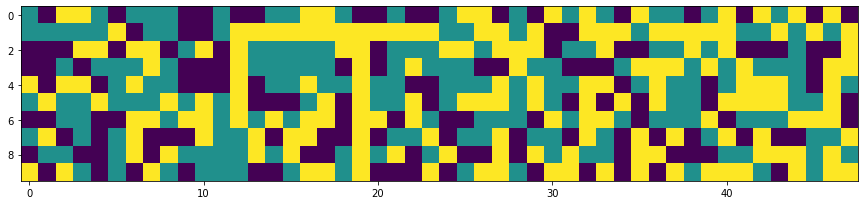

In [13]:
Q = experiment.Q
l_2 = []
for row in Q:
    l = []
    for column in row:
        max_action = np.argmax(column[0])
        l.append(max_action)
    l_2.append(np.array(l))
l = np.array(l_2)
#print(l)
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(l)

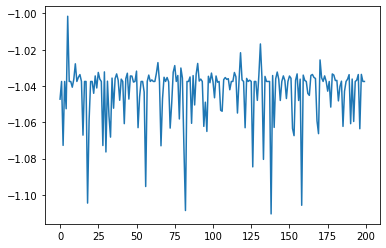

In [11]:
rewards = experiment.reward_list
plt.plot(rewards)

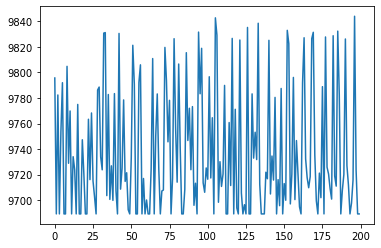

In [12]:
averages = experiment.average_list
plt.plot(averages)